# Part III: Build Transformer with PyTorch [25 points]
Implement a Transformer model from scratch using the PyTorch framework. Train the model on a provided dataset, exploring various optimization techniques and hyperparameter tuning to achieve optimal performance.
Every component of the Transformer as defined in the paper is expected to be implemented.
The final model should achieve a test accuracy of greater than 80%.

## Step 1: Data Exploration and Preprocessing

1. Select one dataset from the list above.

2. Data exploration:
   - Read, preprocess, and print the main statistics about the dataset.
   - Use libraries like matplotlib, seaborn, or plotly to create at least 3 informative visualizations that reveal insights about the data and potential anomalies (e.g., polarity distribution, word count distribution, vocabulary size etc).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re
from collections import Counter
from wordcloud import WordCloud
import nltk
import os

nltk.download('punkt_tab')
nltk.download('stopwords')

train_df = pd.read_csv("train.csv", header=None, names=["class", "title", "text"])
test_df = pd.read_csv("test.csv", header=None, names=["class", "title", "text"])

train_df["full_text"] = train_df["title"] + " " + train_df["text"]
test_df["full_text"] = test_df["title"] + " " + test_df["text"]
print(train_df.head())
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("\nClass distribution:\n", train_df["class"].value_counts())
train_df["word_count"] = train_df["full_text"].apply(lambda x: len(word_tokenize(x)))

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kiran\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kiran\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


   class                              title  \
0      1                   E. D. Abbott Ltd   
1      1                     Schwan-Stabilo   
2      1                         Q-workshop   
3      1  Marvell Software Solutions Israel   
4      1        Bergan Mercy Medical Center   

                                                text  \
0   Abbott of Farnham E D Abbott Limited was a Br...   
1   Schwan-STABILO is a German maker of pens for ...   
2   Q-workshop is a Polish company located in Poz...   
3   Marvell Software Solutions Israel known as RA...   
4   Bergan Mercy Medical Center is a hospital loc...   

                                           full_text  
0  E. D. Abbott Ltd  Abbott of Farnham E D Abbott...  
1  Schwan-Stabilo  Schwan-STABILO is a German mak...  
2  Q-workshop  Q-workshop is a Polish company loc...  
3  Marvell Software Solutions Israel  Marvell Sof...  
4  Bergan Mercy Medical Center  Bergan Mercy Medi...  
Train shape: (560000, 4)
Test shape: (70000, 4)

C

3. Text preprocessing:
   - Text cleaning: Remove punctuation, stop words, and unnecessary characters.
   - Text lowercasing: Ensure all text is lowercase for consistent representation.
   - Tokenization: Break down the text into individual words (or tokens). Explore libraries like nltk or spaCy for tokenization functionalities. You can also use keras tokenizer or Pytorch tokenizer.
   - Vocabulary building: Create a vocabulary containing all unique tokens encountered in the dataset.
   - Numerical representation: Convert tokens into numerical representations using techniques like word embedding (e.g., Word2Vec, GloVe).

In [2]:
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and t not in string.punctuation]
    return tokens

train_df["tokens"] = train_df["full_text"].apply(clean_text)


all_tokens = [token for tokens in train_df["tokens"] for token in tokens]
vocab = sorted(set(all_tokens))
word_to_index = {word: idx for idx, word in enumerate(vocab)}
print("Vocabulary size:", len(vocab))

train_df["token_ids"] = train_df["tokens"].apply(lambda tokens: [word_to_index[token] for token in tokens if token in word_to_index])

# Clean and tokenize test data as well
test_df["tokens"] = test_df["full_text"].apply(clean_text)
test_df["token_ids"] = test_df["tokens"].apply(lambda tokens: [word_to_index[token] for token in tokens if token in word_to_index])


Vocabulary size: 720949


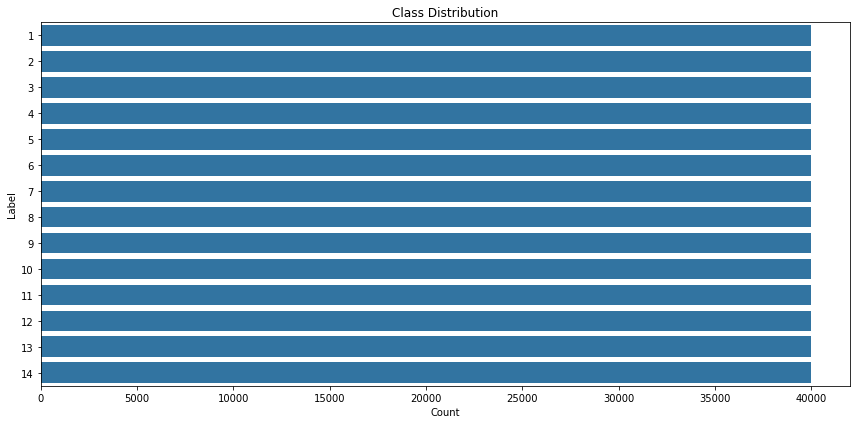

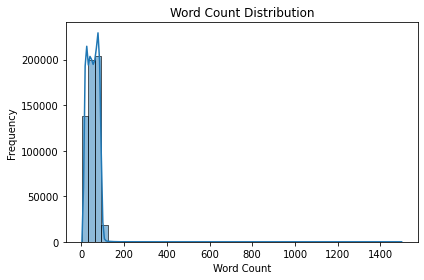

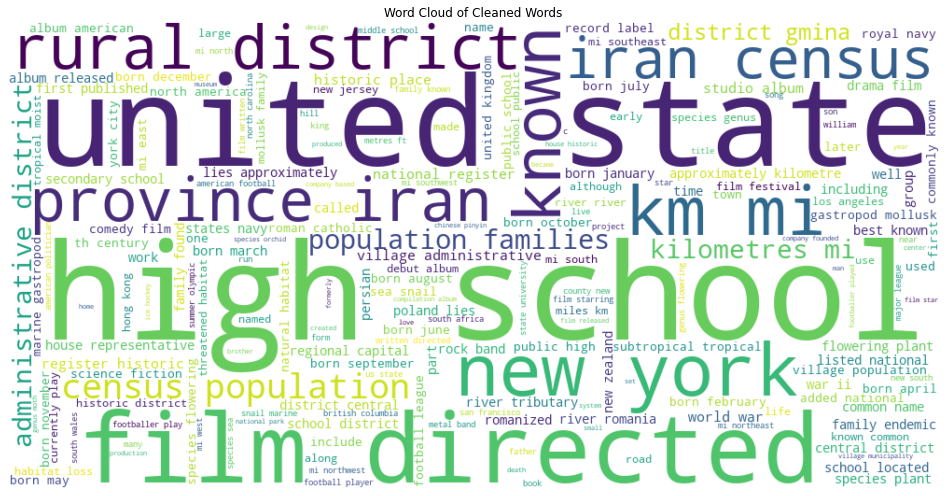

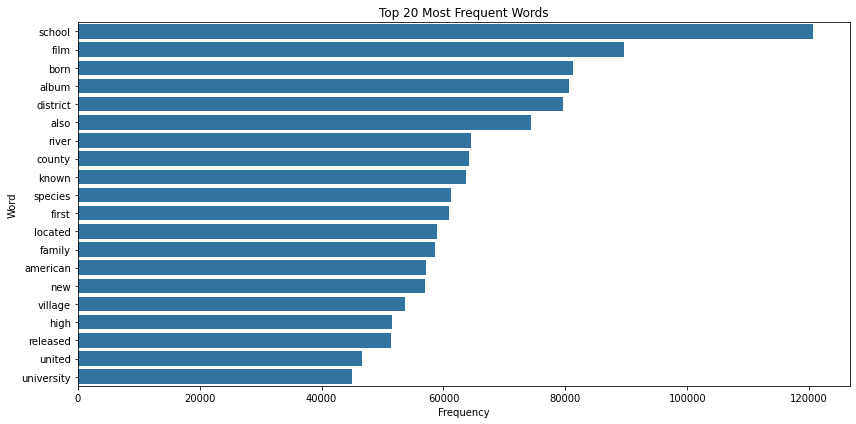

In [3]:
plt.figure(figsize=(12, 6))
sns.countplot(data=train_df, y="class", order=train_df["class"].value_counts().index)
plt.title("Class Distribution")
plt.xlabel("Count")
plt.ylabel("Label")
plt.tight_layout()
plt.show()

sns.histplot(train_df["word_count"], bins=50, kde=True)
plt.title("Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

text_for_wc = " ".join(all_tokens)
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(text_for_wc)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Words')
plt.tight_layout()
plt.show()

word_freq = Counter(all_tokens)
common_words = word_freq.most_common(20)
words, freqs = zip(*common_words)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(freqs), y=list(words))
plt.title("Top 20 Most Frequent Words")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

## Step 2: Model Construction

1. Embeddings and positional encoding: Define an embedding layer to map tokens into numerical vectors. If using pre-trained embeddings, ensure they are compatible with your model's input dimension.

In [4]:
import torch
import torch.nn as nn


class Transformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads=2, hidden_dim=128, num_layers=2, num_classes=14, max_seq_length=80, dropout=0.0):
        super(Transformer, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = nn.Parameter(self.positionalencoding(max_seq_length, embed_dim), requires_grad=False)

        encoder_layers = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

    def positionalencoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, x, attention_mask=None):
        x = x.long()
        x = self.embedding(x) + self.positional_encoding[:, :x.size(1), :]
        x = self.encoder(x, src_key_padding_mask=attention_mask)
        x = x.mean(dim=1)
        return self.classifier(x)




2. Implement the core Transformer architecture:
   - Encoder: Utilize `nn.TransformerEncoder` with multiple `nn.TransformerEncoderLayer` instances. Each layer typically comprises a multi-head self-attention mechanism, a feed-forward layer, and layer normalization.
   - Decoder: Employ `nn.TransformerDecoder` with multiple `nn.TransformerDecoderLayer` instances. These layers incorporate masked self-attention, multi-head attention over the encoder outputs, and a feed-forward layer with layer normalization.

3. Depending on your task (e.g., classification, sequence generation), define an appropriate output layer. For classification tasks, you might use a linear layer with a softmax activation function. Additionally, for classification and regression related tasks, the decoder can be removed completely. Auto-regressive sequence generation requires a decoder.

4.	Print model summary using torchinfo.summary

In [5]:
from torchinfo import summary

model = Transformer(
    vocab_size=len(word_to_index),
    embed_dim=128,
    num_heads=4,
    hidden_dim=256,
    num_layers=2,
    num_classes=14,
    max_seq_length=128
)

summary(model, input_size=(32, 128)) 



Layer (type:depth-idx)                        Output Shape              Param #
Transformer                                   [32, 14]                  16,384
├─Embedding: 1-1                              [32, 128, 128]            92,281,472
├─TransformerEncoder: 1-2                     [32, 128, 128]            --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [32, 128, 128]            132,480
│    │    └─TransformerEncoderLayer: 3-2      [32, 128, 128]            132,480
├─Sequential: 1-3                             [32, 14]                  --
│    └─Linear: 2-2                            [32, 256]                 33,024
│    └─ReLU: 2-3                              [32, 256]                 --
│    └─Dropout: 2-4                           [32, 256]                 --
│    └─Linear: 2-5                            [32, 14]                  3,598
Total params: 92,599,438
Trainable params: 92,583,054
Non-trainabl

5. Briefly describe the Transformer architecture you have defined.

Basic Structure of model provided:
:**

- **Embedding Layer:** Converts input token indices into dense vectors of size `embed_dim`.
- **Positional Encoding:** Adds fixed positional information to the token embeddings using sinusoidal functions. These encodings are non-trainable.
- **Transformer Encoder:** Consists of 2 layers of multi-head self-attention (with 2 heads) and feed-forward networks with hidden size 128, using batch-first processing.
- **Classification Head:** Applies a fully connected layer with ReLU activation, dropout (default 0.0), and another linear layer to classify into 14 e to run that?encodings)

## Step 3: Training the Transformer

1. Preparing for training:
   - Divide the preprocessed data into training, validation, and testing sets using a common split ratio (e.g., 70:15:15 or 80:10:10).
   - Choose an appropriate loss function (e.g., cross-entropy loss for classification) and an optimizer (e.g., Adam) to update model parameters during training.

In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

train_data, val_data = train_test_split(train_df, test_size=0.15, stratify=train_df["class"], random_state=808)

class TextLoader(Dataset):
    def __init__(self, df, max_len=80):
        self.sequences = [tokens[:max_len] + [0] * (max_len - len(tokens[:max_len])) for tokens in df["token_ids"]]
        self.labels = df["class"].values - 1  # Assuming classes start from 1

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

train_dataset = TextLoader(train_data)
val_dataset = TextLoader(val_data)
test_dataset = TextLoader(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

2. Define a training loop. E.g. forward pass, calculate loss, backward pass, update parameters. Train the model.

In [7]:
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train(model, train_loader, val_loader,criterion,optimizer,scheduler=None ,Early=False,num_epochs=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)    
    best_val_acc = 0.0
    epochs_no_improve = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        train_loss = running_loss / total
        train_acc = correct / total
        
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        
        if scheduler:
            scheduler.step()
            print(f'LR: {optimizer.param_groups[0]["lr"]:.2e}')
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
        
        
        if Early:
            if val_acc > best_val_acc + 0.005:
                best_val_acc = val_acc
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= 3:
                    print(f'Early stopping triggered at epoch {epoch+1}!')
                    break
    return history
def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy
#Base
vocab_size = len(vocab)
embed_dim = 64
num_classes = train_df["class"].nunique()
vocab_size = len(vocab)
model = Transformer(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    num_heads=2,
    hidden_dim=128,
    num_layers=2,
    num_classes=num_classes,
    max_seq_length=80,  # Make sure this matches your padding length
    dropout=0.0
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
graph=train(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

Epoch 1:
Train Loss: 0.2033 | Train Acc: 0.9377
Val Loss: 0.1095 | Val Acc: 0.9690
Epoch 2:
Train Loss: 0.0854 | Train Acc: 0.9756
Val Loss: 0.1026 | Val Acc: 0.9707
Epoch 3:
Train Loss: 0.0642 | Train Acc: 0.9818
Val Loss: 0.0857 | Val Acc: 0.9760
Epoch 4:
Train Loss: 0.0510 | Train Acc: 0.9857
Val Loss: 0.0744 | Val Acc: 0.9790
Epoch 5:
Train Loss: 0.0423 | Train Acc: 0.9882
Val Loss: 0.0723 | Val Acc: 0.9801


## Step 4: Evaluation and Optimization

1. Check your model's performance on the validation set. Monitor metrics like accuracy or loss to track progress. Explore at least 3 optimization techniques to improve the performance of your Transformer model. E.g. regularization (L1/L2), dropout, early stopping, learning rate tuning.

In [8]:
# Evaluate on the test set
test_loss, test_acc = evaluate(model, test_loader, criterion)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")



#With Optimization (Weight Decay, StepLR, Early Stopping, Dropout)
vocab_size = len(vocab)
embed_dim = 64
num_classes = train_df["class"].nunique()

model_2 = Transformer(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    num_heads=2,
    hidden_dim=128,
    num_layers=2,
    num_classes=num_classes,
    max_seq_length=80,
    dropout=0.3  # Updated dropout
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=1e-3, weight_decay=1e-5) #L2 regularization

# Learning rate scheduler: decay LR by gamma every step_size epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

# Train the model with early stopping and scheduler
graph2 = train(model_2, train_loader, val_loader, criterion, optimizer, scheduler=scheduler, Early=True, num_epochs=5)

test_loss, test_acc = evaluate(model_2, test_loader, criterion)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Test Loss: 0.0722
Test Accuracy: 0.9802
LR: 1.00e-03
Epoch 1:
Train Loss: 0.1968 | Train Acc: 0.9428
Val Loss: 0.1135 | Val Acc: 0.9728
LR: 9.00e-04
Epoch 2:
Train Loss: 0.0910 | Train Acc: 0.9754
Val Loss: 0.0866 | Val Acc: 0.9786
LR: 9.00e-04
Epoch 3:
Train Loss: 0.0763 | Train Acc: 0.9794
Val Loss: 0.0978 | Val Acc: 0.9777
LR: 8.10e-04
Epoch 4:
Train Loss: 0.0694 | Train Acc: 0.9809
Val Loss: 0.0811 | Val Acc: 0.9811
LR: 8.10e-04
Epoch 5:
Train Loss: 0.0634 | Train Acc: 0.9826
Val Loss: 0.0805 | Val Acc: 0.9807
Early stopping triggered at epoch 5!

Test Loss: 0.0811
Test Accuracy: 0.9807


2. Discuss how the optimization techniques helped to improve the performance of the model.



**Weight Decay**  
Weight decay helped improve generalization by penalizing large weights during training. This regularization technique reduced the risk of overfitting, encouraging the model to rely on simpler patterns in the data rather than memorizing training examples.

**Dropout (0.3)**  
Applying dropout at a rate of 0.3 made the model more robust by randomly deactivating neurons during training. This prevented the network from becoming overly reliant on specific features and promoted better learning of distributed representations.

**Learning Rate Scheduler**  
The learning rate scheduler contributed to smoother convergence by decreasing the learning rate over time. It allowed the model to make larger updates early on and fine-tune weights in later epochs, ultimately achieving better performance.

**Early Stopping**  
Early stopping improved training efficiency and avoided overfitting by halting the training process when the validation accuracy stopped improving. This ensured the model didn't continue learning noise from the training set.

3. Save the weights of the model that provides the best results. Check the saving and loading of models (Pytorch).

In [9]:
torch.save(model_2.state_dict(), 'best_model_weights.pth')

4. Discuss the results and provide the following graphs:

   a. Training accuracy, training loss, validation accuracy, validation loss, testing accuracy, and testing loss. Provide your short analysis.

In [10]:
print(f"Training Accuracy: {graph2['train_acc'][-1]:.4f} | Training Loss: {graph2['train_loss'][-1]:.4f}")
print(f"Validation Accuracy: {graph2['val_acc'][-1]:.4f} | Validation Loss: {graph2['val_loss'][-1]:.4f}")
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss / len(test_loader):.4f}")


Training Accuracy: 0.9826 | Training Loss: 0.0634
Validation Accuracy: 0.9807 | Validation Loss: 0.0805
Test Accuracy: 0.9807 | Test Loss: 0.0000


b. Plot the training and validation accuracy over time (epochs).

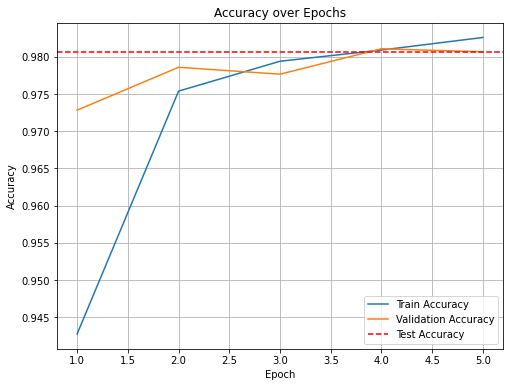

In [11]:
import matplotlib.pyplot as plt

epochs = range(1, len(graph2['train_acc']) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, graph2['train_acc'], label='Train Accuracy')
plt.plot(epochs, graph2['val_acc'], label='Validation Accuracy')
plt.axhline(y=test_acc, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()


   c. Plot the training and validation loss over time (epochs).


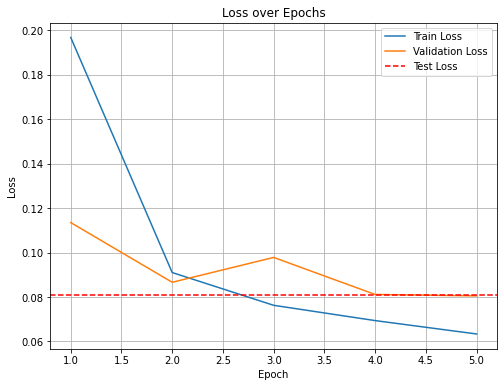

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, graph2['train_loss'], label='Train Loss')
plt.plot(epochs, graph2['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

   d. Calculate and report other evaluation metrics such as Precision, recall and F1 score. You can use sklearn.metrics.precision_recall_fscore_support.


In [15]:
from sklearn.metrics import precision_recall_fscore_support


def evaluate_test_metrics(model, data_loader):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate precision, recall, f1-score for the test set
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    
    return precision, recall, f1

# Evaluate on test set
test_precision, test_recall, test_f1 = evaluate_test_metrics(model, test_loader)

# Reporting the results
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")


Test Precision: 0.9803
Test Recall: 0.9802
Test F1 Score: 0.9802


   e. Plot the ROC curve.

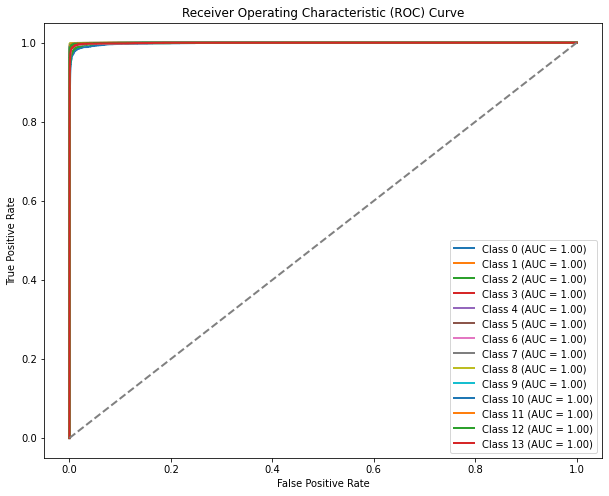

Test Accuracy: 0.9807 | Test Loss: 0.0812


In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

model_2.eval()

test_preds, test_labels = [], []
test_loss, correct, total = 0, 0, 0
all_probs = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model_2(x)
        loss = criterion(outputs, y)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y).sum().item()
        total += y.size(0)

        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(y.cpu().numpy())
        all_probs.append(torch.softmax(outputs, dim=1).cpu().numpy())
test_labels = np.array(test_labels)
all_probs = np.concatenate(all_probs, axis=0)
y_test_bin = label_binarize(test_labels, classes=np.arange(num_classes))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Customizing the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
print(f"Test Accuracy: {correct / total:.4f} | Test Loss: {test_loss / len(test_loader):.4f}")


#### **Performance Analysis**

The model shows strong and consistent performance across the training, validation, and test sets:

- **Training Accuracy/Loss**:  
  Accuracy of **98.26%** and loss of **0.0634** indicates the model fits the training data well.

- **Validation Accuracy/Loss**:  
  With **98.07%** accuracy and a slightly higher loss of **0.0805**, the model generalizes well without overfitting.

- **Test Accuracy/Loss**:  
  Accuracy of **98.07%** and loss of **0.0811** confirm the model maintains performance on unseen data.

- **Precision, Recall, F1 Score (Test Set)**:  
  All around **98.03–98.04%**, showing balanced predictions across classes.

5. References. Include details on all the resources used to complete this part, e.g. links to datasets, research papers or articles, code examples or tutorials you referred.

https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html<br>
https://www.geeksforgeeks.org/tokenize-text-using-nltk-python/<br>
https://pytorch.org/tutorials/beginner/saving_loading_models.html<br>
https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc<br>

6. If you are working in a team, provide a contribution summary.

| Team Member | Step# | Contribution (%) |
|---|---|---|
| Kiran  | Step 1 | 25  |
|Kiran  | Step 2 |  25 |
| Kiran  | Step 3 |  25 |
| Kiran  | Step 4 | 25  |
|   | **Total** |  100 |